In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import itertools
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
df.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'tweet']
df.head()

,sentiment,ID,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
data = df.drop(['ID', 'date', 'query', 'username'], axis = 1)
sent = { 0: 'Negative', 4: 'Positive'}
def label_decoder(label):
    return sent[label]

data.sentiment = data.sentiment.apply(lambda x : label_decoder(x))
data.head()

,sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

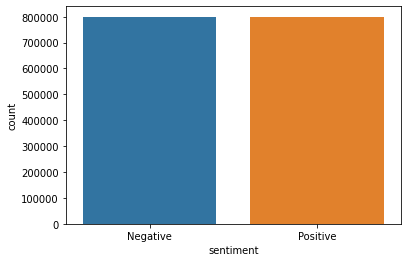

In [6]:
plt.figure()
sns.countplot(data['sentiment'])

In [7]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text, stem = False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens =[]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [8]:
data.tweet[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [9]:
preprocess(data.tweet[0], True)

'awww bummer shoulda got david carr third day'

In [10]:
data.tweet = data.tweet.apply(lambda x : preprocess(x))
data.head()

,sentiment,tweet
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


In [11]:
Train_size = 0.8
max_words = 100000
max_length = 30

In [12]:
train_data, test_data = train_test_split(data, test_size = 1 - Train_size, random_state = 5)
print('size of training data :', len(train_data))
print('size of testing data :',len(test_data))

size of training data : 1280000
size of testing data : 320000


In [13]:
train_data.head()

,sentiment,tweet
887460,Positive,ahaha honestly im even tired suprise woke sooo...
545899,Negative,wtf goldfish hate keep dying poor
835785,Positive,serious finish things
277841,Negative,come think one one tanga ako
1124354,Positive,started following mind direct messaging tell know


In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('VOCAB_SIZE :', vocab_size)

VOCAB_SIZE : 290739


In [15]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = max_length)

print('training x shape :', x_train.shape)
print('testing x shape :', x_test.shape)

training x shape : (1280000, 30)
testing x shape : (320000, 30)


In [16]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.tolist())
y_test = encoder.transform(test_data.sentiment.tolist())

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000,)
y_test shape : (320000,)


In [17]:
y_train = y_train.reshape(1280000,1)
y_test = y_test.reshape(320000,1)

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000, 1)
y_test shape : (320000, 1)


In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-04 11:40:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-04 11:40:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-04 11:40:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [19]:
GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 12
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [20]:
embeddings_index = {}
file = open(GLOVE_EMB)
for line in file:
    values = line.split()
    word = value = values[0]
    coef = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coef
    
file.close()
print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


In [21]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                           EMBEDDING_DIM,
                                           weights = [embedding_matrix],
                                           input_length = max_length,
                                           trainable = False)

In [23]:
sequence_input = Input(shape = (max_length), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
# x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

2023-01-04 11:43:37.351885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 11:43:37.495998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 11:43:37.496761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 11:43:37.497878: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87221700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [25]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss ='binary_crossentropy',
             metrics = ['accuracy'])

LR_reduction = ReduceLROnPlateau(factor = 0.1,
                                min_lr = 0.0001,
                                monitor = 'val_loss',
                                verbose = 1)

In [26]:
history = model.fit(x_train,
                   y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (x_test, y_test),
                   callbacks = [LR_reduction])

2023-01-04 11:43:41.365571: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 153600000 exceeds 10% of free system memory.
2023-01-04 11:43:41.548562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2023-01-04 11:43:45.549852: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.7397

2023-01-04 11:45:54.487336: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 38400000 exceeds 10% of free system memory.


1250/1250 [==============================] - 137s 102ms/step - loss: 0.5188 - accuracy: 0.7397 - val_loss: 0.4830 - val_accuracy: 0.7648
Epoch 2/12
1250/1250 [==============================] - 127s 102ms/step - loss: 0.4866 - accuracy: 0.7628 - val_loss: 0.4714 - val_accuracy: 0.7723
Epoch 3/12
1250/1250 [==============================] - 127s 101ms/step - loss: 0.4768 - accuracy: 0.7696 - val_loss: 0.4687 - val_accuracy: 0.7761
Epoch 4/12
1250/1250 [==============================] - 126s 101ms/step - loss: 0.4703 - accuracy: 0.7735 - val_loss: 0.4648 - val_accuracy: 0.7779
Epoch 5/12
1250/1250 [==============================] - 132s 105ms/step - loss: 0.4659 - accuracy: 0.7763 - val_loss: 0.4629 - val_accuracy: 0.7782
Epoch 6/12
1250/1250 [==============================] - 125s 100ms/step - loss: 0.4627 - accuracy: 0.7782 - val_loss: 0.4603 - val_accuracy: 0.7797
Epoch 7/12
1250/1250 [==============================] - 125s 100ms/step - loss: 0.4596 - accuracy: 0.7799 - val_loss: 0.459

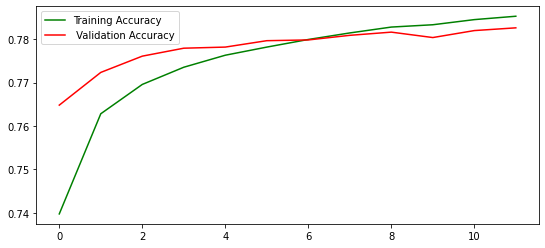

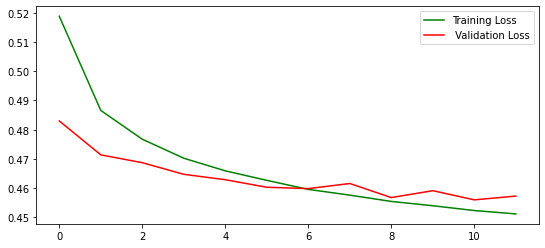

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.figure(figsize = (9,4))
plt.plot(acc, color = 'green', label = 'Training Accuracy')
plt.plot(val_acc, color = 'red', label = ' Validation Accuracy')
plt.legend()

plt.figure(figsize= (9,4))
plt.plot(loss,color = 'green', label = 'Training Loss')
plt.plot(val_loss, color = 'red', label = ' Validation Loss')
plt.legend()

In [28]:
def decode_sentiment(score):
    return 'Positive' if score > 0.5 else 'Negative'

scores = model.predict(x_test, verbose = 1, batch_size = 10000)
y_pred_D = [decode_sentiment(score) for score in scores]

2023-01-04 12:10:02.656664: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 38400000 exceeds 10% of free system memory.


32/32 [==============================] - 2s 39ms/step


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
  """
  This Function prints and plots the Confusion Matrix.
  Normalization can be applied by setting 'normalize=true'.
  """
  plt.imshow(cm, interpolation = 'nearest', cmap =cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes,rotation = 30)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm= cm.astype('float')/ cm.sum(axis = 1[:, np.newaxis])
    print("Normalized Confusion Matrix")
  else:
    print('Confusion matrix, without Normalization')

  #print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment= 'center',
             color = "white" if cm[i,j]>thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label')

Confusion matrix, without Normalization


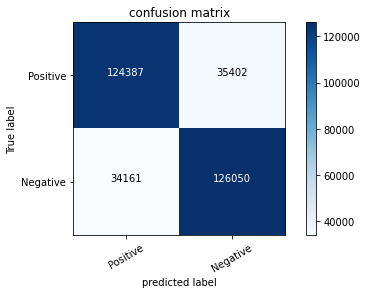

In [32]:
cnf_matrix = confusion_matrix(test_data.sentiment.tolist(), y_pred_D)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = test_data.sentiment.unique(), title = 'confusion matrix')
plt.show()

In [33]:
accuracy = max(acc)
print('Accuracy of model :', accuracy)

Accuracy of model : 0.7852867245674133


In [34]:
print(classification_report(list(test_data.sentiment), y_pred_D))

              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78    159789
    Positive       0.78      0.79      0.78    160211

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [37]:
def pred(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length) 
    score = model.predict([x_test])[0]
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [38]:
pred("its very honored to see this")

{'label': 'Positive',
 'score': 0.9493657350540161,
 'elapsed_time': 0.42757654190063477}